### Grad-CAM
In this notebook we calculate Gradcam and activation map of our two best CNN models (effnetB4 and Vgg16)
The activation function of last layers were 'relu' function.

Written by
### Salma Kazemi Rashed
The code is partly taken from https://arxiv.org/abs/1610.02391 paper and revised for our model and script


In [2]:
##libraries 
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from pathlib import Path
from PIL import Image

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout,LeakyReLU
from tensorflow.keras.models import Model, model_from_json

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D,MaxPool2D

from keras import backend as K
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB4,EfficientNetB7

import tensorflow as tf
import numpy as np
import keras
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.models import load_model
import seaborn as sns
#############


## **GRAD-CAM**
     1. Define metrics
     
     2. load matched weights
     
     3. define the network with new probes 
   
     4. calculate gradcam

### 1. Define metrics to track in 3 class classificaion models

In [3]:
### This class was defined in our model for 3 class classifier
### Define again here 
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)
###########################################################################################

### Important Variables and Path

In [4]:
VALIDATION_DIR = ['2nd_part']#['1st_part','2nd_part','3rd_part']
MODELS         = '../../models/initial_relu/3fold_CV/vgg_aug_3fold/'
SAMPLES        = '../../results/Grad_cam/initial_relu/samples_V_r_a/main_img_'
LAYER_TYPE     = 'relu'

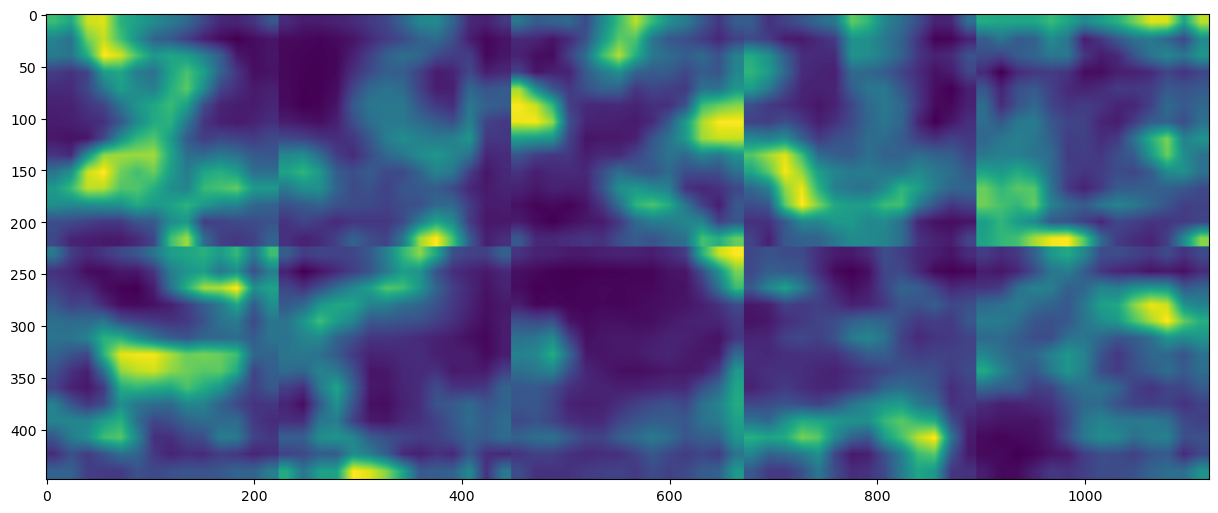

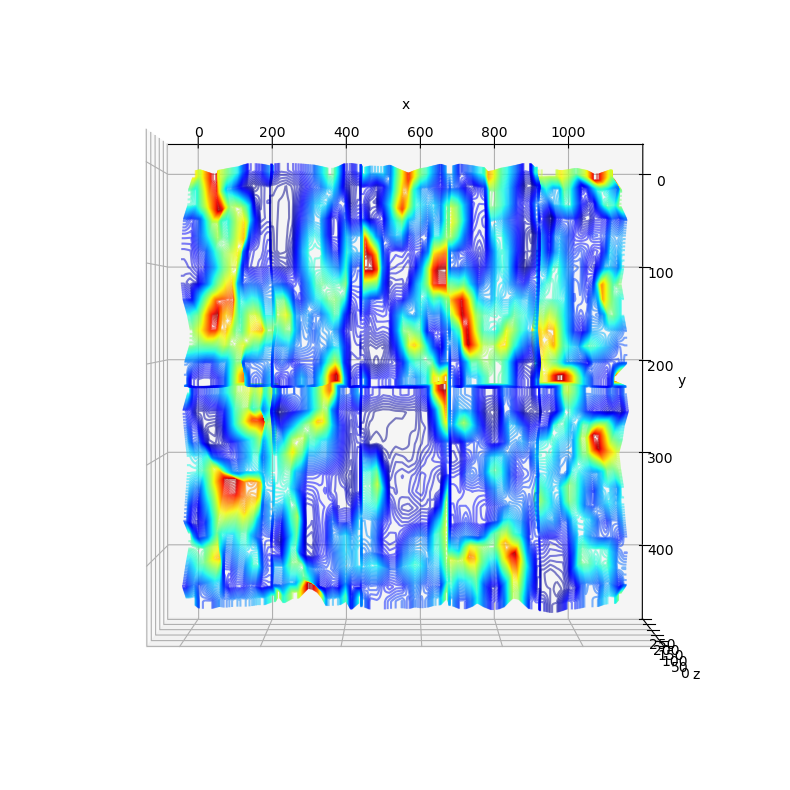

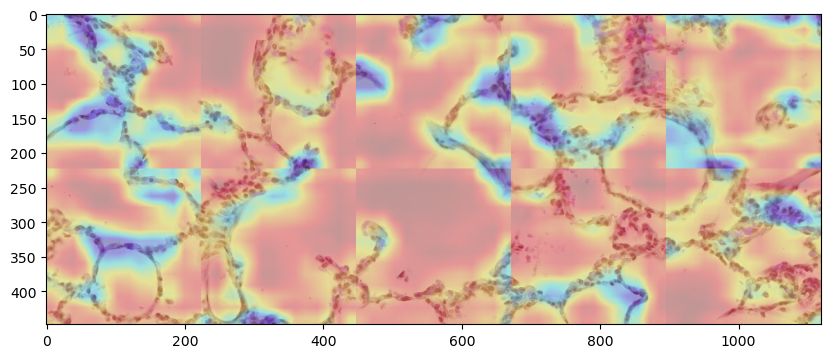

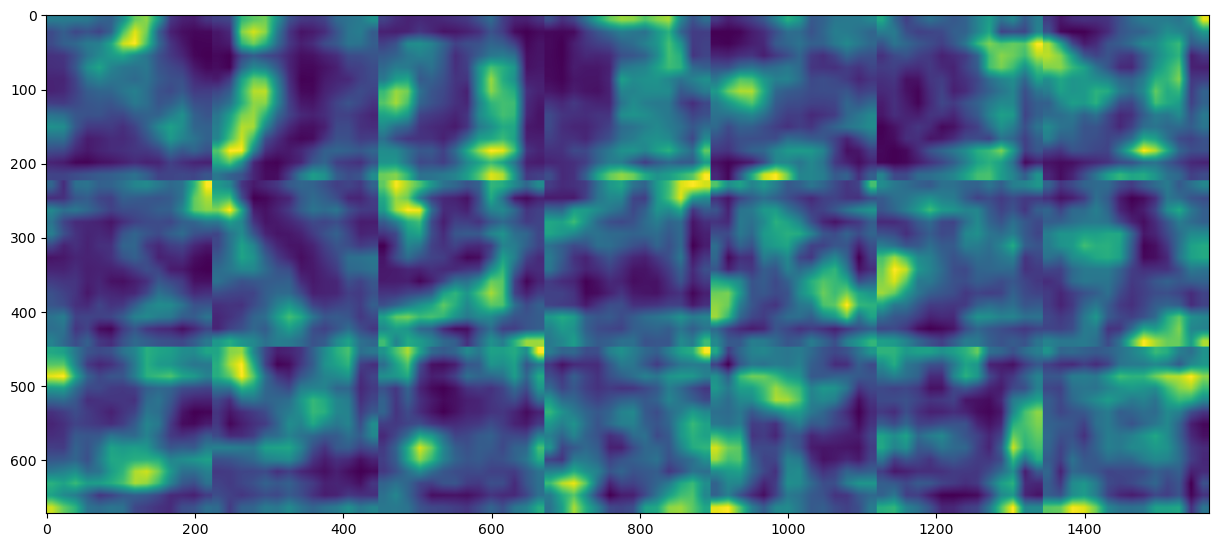

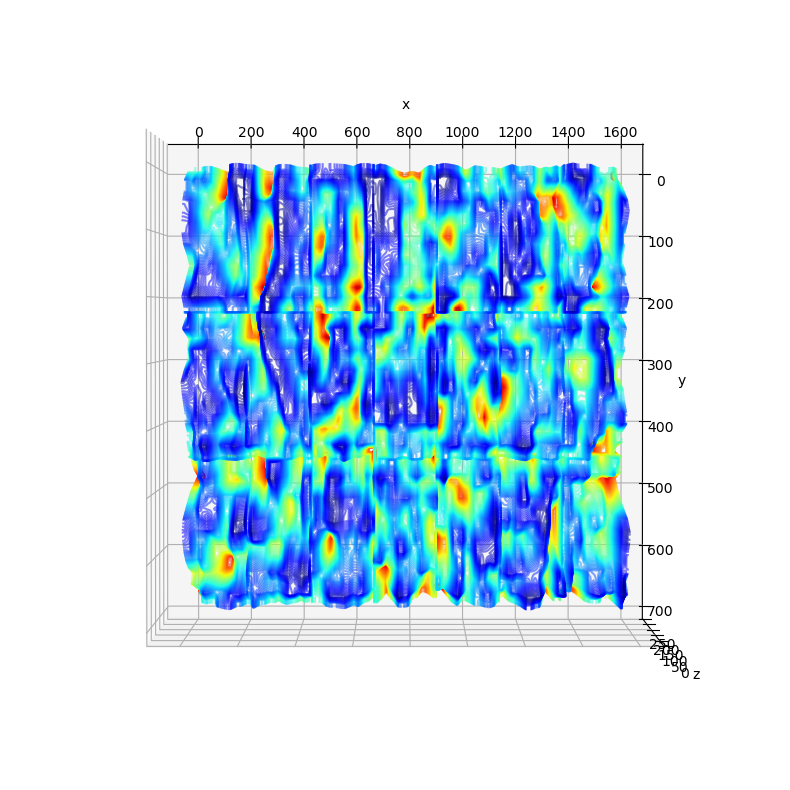

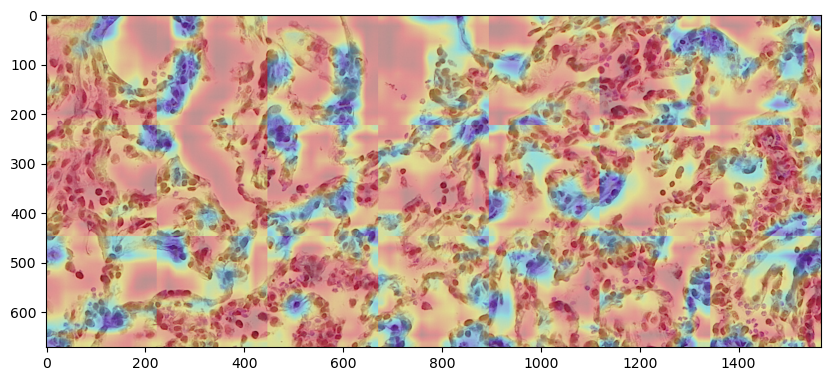

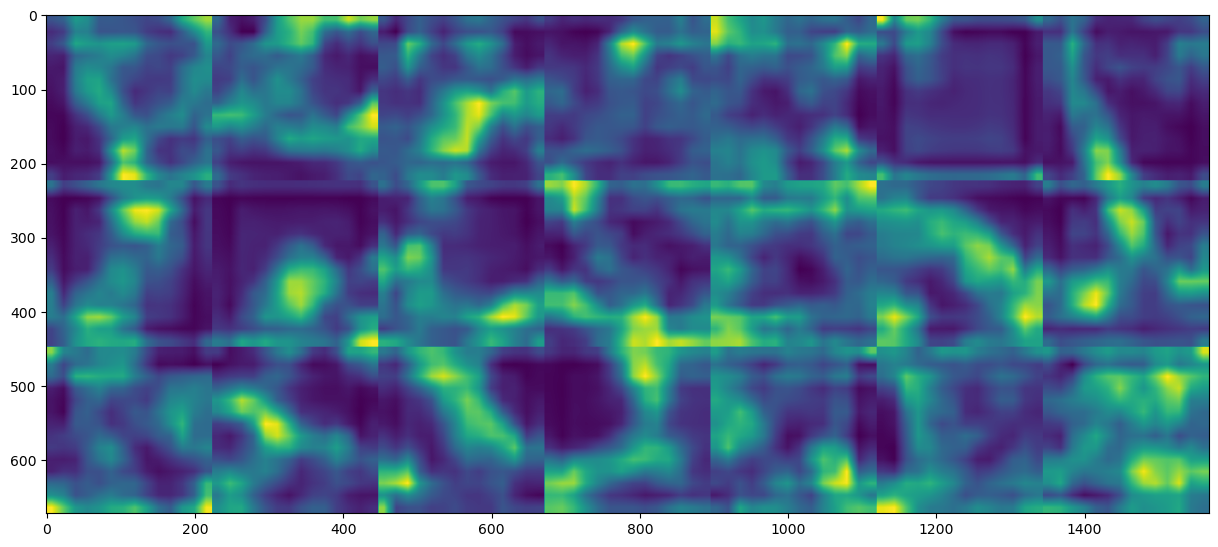

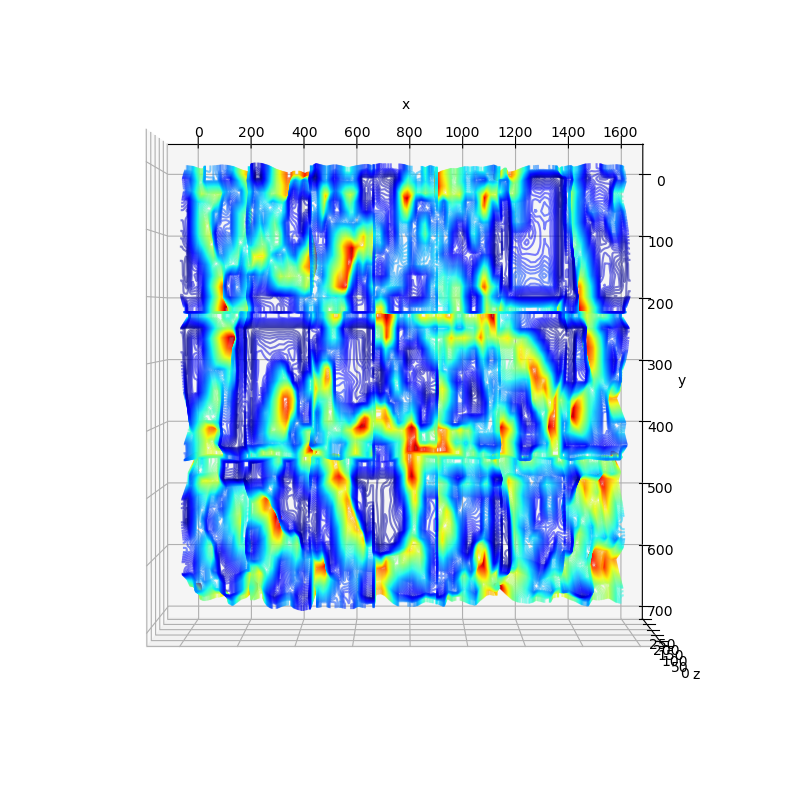

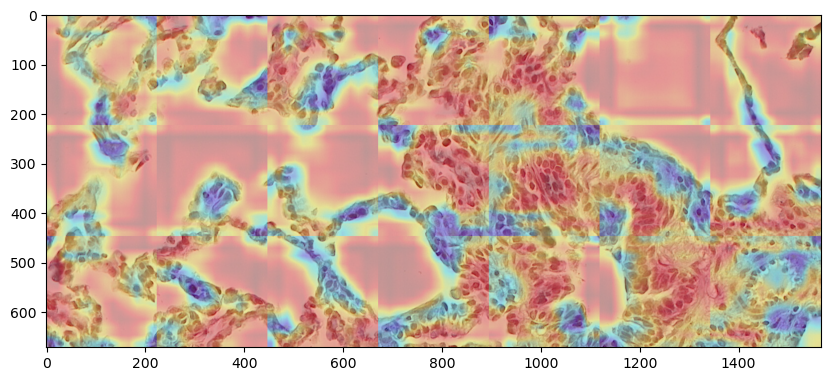

In [5]:

###########################################################################################
### We had 3 folds here each as validation set
val_dirs = VALIDATION_DIR
###############################################
### We went through all folds and check 3 models 



for val_dir in val_dirs:
    ############################# Functional model ##################################################
    inputs = tf.keras.Input(shape=(224,224,3))  ## This is very important to define functional API 
    ## Base model (VGG16)
    x = VGG16(                                
      input_tensor=inputs, 
      include_top=False,
      weights='imagenet')  ## Pretrained weights

    x.trainable = False  ## Layers are not trainable

    ## Change top layers
    layer_type = LAYER_TYPE
    x = tf.keras.layers.Flatten(name='flatten')(x.output)
    x = tf.keras.layers.Dense(128, activation=layer_type, name='fc1')(x)
    x = tf.keras.layers.Dense(128, activation=layer_type, name='fc2')(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
    x = tf.keras.layers.Dense(3, activation='softmax', name='predictions')(x)
    
    '''
    block5_conv3 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
    block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
                                                                 
    flatten (Flatten)           (None, 25088)             0         
                                                                 
    fc1 (Dense)                 (None, 128)               3211392   
                                                                 
    fc2 (Dense)                 (None, 128)               16512     
                                                                 
    dropout (Dropout)           (None, 128)               0         
                                                                 
    predictions (Dense)         (None, 3)                 387       
                                                                 
    =================================================================
    Total params: 17,942,979
    Trainable params: 3,228,291
    Non-trainable params: 14,714,688
    _________________________________________________________________
    '''
    ## Here we define metrics for multi-class classifier
    METRICS = [
      keras.metrics.SparseCategoricalAccuracy(),
      MulticlassTruePositives()]
 
    pretrained_model = tf.keras.Model(inputs, x)
    
    
    ## Compile model 
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=METRICS)
    ## After defining the functional model we will have a model loaded from weights
    
    
    
    ############################ Loaded model from Weights #############################################
    ##weights saved before 
    weights = glob.glob(MODELS+'*_best_weights.*')[0]
    
    ### This is the model created from weights
    loaded_1 = keras.models.load_model(
        weights, custom_objects={"MulticlassTruePositives": MulticlassTruePositives,'Functional':VGG16()})
    
    #loaded_1.summary()
    weights_list = loaded_1.get_weights()
    
    ## 2. load matched weights
    #### The layer index differ in weighted and functional models ########################################
    model_index  = [20,21,23]  ## Index of layers in functional model
    weight_index = [3,4,6]     ## Index of layers in weight model 
    
    ####make a for loop to substitue the weights of functional model with the trained weights 
    for i,weights in zip(model_index,weight_index):
        pretrained_model.layers[i].set_weights(loaded_1.layers[weights].get_weights())

    
    
    
    model=pretrained_model
    ##  3. define the network with new probes 
    ################## Define a partial model with new probes from fully connected layers as output###############
    gradModel = Model(
          inputs=[pretrained_model.inputs],
          outputs=[pretrained_model.get_layer('block5_conv3').output,pretrained_model.get_layer('fc1').output,
                   pretrained_model.get_layer('fc2').output,
                   pretrained_model.output])
    
    
    
    ### This is for calculating the gradients or sensitivity manually
    #TestGradientModel  = Model(
    #                     inputs  =[pretrained_model.get_layer('block5_conv3').output],
    #                     outputs =[pretrained_model.output])
    
    ####load sample images for calcuating gradcam matrix
    ######### Sample image directory is defined by model name#############
    ### We wanted to stitch small tiles to get the bigger image
    
    
    
    imgs = glob.glob(SAMPLES+val_dir+'/*.tif')
    ## repeat for all images
    
    for im in imgs:
        img_path = im
        
        if cv2.imread(img_path) is not None: ## Check if the image exists
            input_img = cv2.imread(img_path)
            
            max_tile_i = int(np.floor(input_img.shape[0]/224))  ##maxiumum number of rows
            max_tile_j = int(np.floor(input_img.shape[1]/224))  ##maxiumum number of columns
            
            ##initialization
            Heatmap_2D   = np.zeros([max_tile_i*224,max_tile_j*224])
            Heatmap_only = np.zeros([max_tile_i*224,max_tile_j*224,1])
            Gradcam_img  = np.zeros([max_tile_i*224,max_tile_j*224,3])
            
            ### We need to feed the tiles into model to get the activation map
            for i in range(max_tile_i):
                for j in range(max_tile_j):
                    tmp_img = input_img[224*i:224*(i+1),224*j:224*(j+1),:]
                    tmp_img = cv2.resize(tmp_img,(224,224))
                    y = np.expand_dims(tmp_img, axis=0)  
                    img_array = y

                    ## 4. calculate gradcam
                    
                    ## We need to calculate the gradient of output loss w.r.t the prob layer
                    with tf.GradientTape() as tape:
                        # cast the image tensor to a float-32 data type, pass the
                        # forward propagate the image through the gradient model, and grab the loss
                        # associated with the specific class index
                        
                        ## The input image
                        inputs = tf.cast(img_array, tf.float32)
                        ## The probes as last conv layers, fully connected layers and predictions 
                        convOutputs, fc1,fc2,predictions = gradModel(inputs)  ## We just took the prob we defined before

                        
                        
                        ### Loss is the final output probablity before softmax layer
                        loss = predictions[:, np.argmax(predictions)]
                        img_title = 'predicted score: '+ str( np.argmax(predictions))
                        
                        
                        # use automatic differentiation to compute the gradients
                        grads = tape.gradient(loss, convOutputs) ## we can calculate this manually
                        ### by changing each element in the (14, 14, 512 ) map calculate the diff in the loss (dy/dx)
                        #print(grads.shape) = (14,14,512) in VGG16
                        ##################################################################################
                        ## manual calculation 
                         
                        #d_loss    = TestGradientModel(convOutputs)
                        #ind    = np.argmax(predictions)
                        #loss = predictions[:, 0]
                        
                        #new_grads = tf.reshape(grads,(1,14*14*512)).numpy()
                        #new_conv  = tf.reshape(convOutputs,(1,14*14*512))
                        #new_shape_grads = tf.reshape(new_grads,(1,14*14*512))
                        
                        #for n_c in range(len(new_conv[0,:])):
                        #    temp_conv  = new_conv.numpy()
                        #    temp_conv[0,n_c] = new_conv[0][n_c]*1.5+1e-5
                        #    temp_conv   = tf.reshape(temp_conv,(1,14,14,512))
                        #    d_loss_d_conv = (TestGradientModel(temp_conv)[:,0]-loss)/(new_conv[0,n_c]*0.5+1e-5)
                        #    new_grads[0,n_c] = d_loss_d_conv   
                        #new_grads = tf.reshape(new_grads,(1,14,14,512))
                        ##################################################################################
                        
                        
                        
                        ##################################################################################
                    

                        #compute the guided gradients (This is for taking only positive part)
                        castConvOutputs = tf.cast(convOutputs > 0, "float32")##
                        castGrads = tf.cast(grads > 0, "float32")
                        #print(castConvOutputs.shape) =  ( 1,14,14,512 )
                        #print(castGrads.shape)     =   (1,14,14,512)
                        guidedGrads = castConvOutputs * castGrads * grads 
                        #print(guidedGrads.shape)   = (1,14,14,512)

                      # the convolution and guided gradients have a batch dimension
                      # (which we don't need) so let's grab the volume itself and
                      # discard the batch
                        convOutputs = convOutputs[0]  
                        #print(convOutputs.shape)  =  (14,14,512)
                        guidedGrads = guidedGrads[0]
                        #print(guidedGrads.shape)  =  (14,14,512)

                      # compute the average of the gradient values, and using them
                      # as weights, compute the ponderation of the filters with
                      # respect to the weights
                        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
                        #print(weights.shape)  = 512  (took mean over axis 0  and 1 (14,14))

                        
                        
                        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
                        #print(cam.shape) = 512 * (14, 14, 512)  = (14,14)
                      # grab the spatial dimensions of the input image and resize
                      # the output class activation map to match the input image dimensions
                        (w, h) = (img_array.shape[2], img_array.shape[1])  ## (224,224) here
                        heatmap = cv2.resize(cam.numpy(), (w, h))    ## resize (14,14) to (224,224) (upsample)
                        # normalization
                        numer = heatmap - np.min(heatmap)            
                        denom = (heatmap.max() - heatmap.min())
                        if denom == 0:
                            denom = denom + 0.0000000000000001
                        heatmap = 255*numer / denom

                        Heatmap_2D[224*i:224*(i+1),224*j:224*(j+1)] = heatmap[:,:]
                        ## big heatmap made of smaller tiles
                        
                        
                        stacked_img = np.stack((heatmap,), axis=-1) ## 
                        im_color = cv2.applyColorMap(stacked_img.astype(np.uint8), cv2.COLORMAP_JET) ## add a color map
                        Heatmap_only[224*i:224*(i+1),224*j:224*(j+1)] = stacked_img[:,:,:] 
                        
                        
                        ## add heatmap to image (0.7 image and 0.3 activation heatmap)
                        super_imposed_img = cv2.addWeighted((im_color).astype(np.uint8), 0.3, tmp_img, 0.7,0) 
                        Gradcam_img[224*i:224*(i+1),224*j:224*(j+1),:] =  super_imposed_img 

            ### This part is for plot and saving##########################################
            
            ### Plotting only heatmap
            plt.figure(figsize=(15,15))
            plt.imshow(Heatmap_2D)
            plt.savefig(img_path+'_heatmap.png')
           
            ### Plotting 3D plot of Heatmap as Z axis
            fig   = plt.figure(figsize=(10,10))
            ax    = plt.axes(projection='3d')
            x     = np.arange(0,max_tile_j*224,1)
            y     = np.arange(0,max_tile_i*224,1)
            X, Y  = np.meshgrid(x, y)
            ax.contour3D(X,Y, Heatmap_only[:,:,0], 100,alpha = 0.5, cmap='jet')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.view_init(azim=270, elev=-89)
            plt.savefig(img_path+'_3D.png')


            
            ### Plotting image with GRAD-CAM filter added 
            plt.figure(figsize=(10,10))
            plt.imshow(Gradcam_img.astype(np.uint8))
            norm = mpl.colors.Normalize(vmin=Gradcam_img.min(), vmax=Gradcam_img.max())
            plt.savefig(img_path+'_img_filter.png')


### Repeat the same algorithm for EfficientNetB4 model

    The layers index should be changed since the number of layers in Effnet is so different

### Varibales and Path

In [25]:
VALIDATION_DIR = ['1st_part']##['1st_part','2nd_part','3rd_part']
MODELS         = '../../models/initial_relu/3fold_CV/effnet_aug_3fold_90_rotation/'
SAMPLES        = '../../results/Grad_cam/initial_relu/samples_En_m_a/main_img_'
LAYER_ACTIVATION     = 'relu'

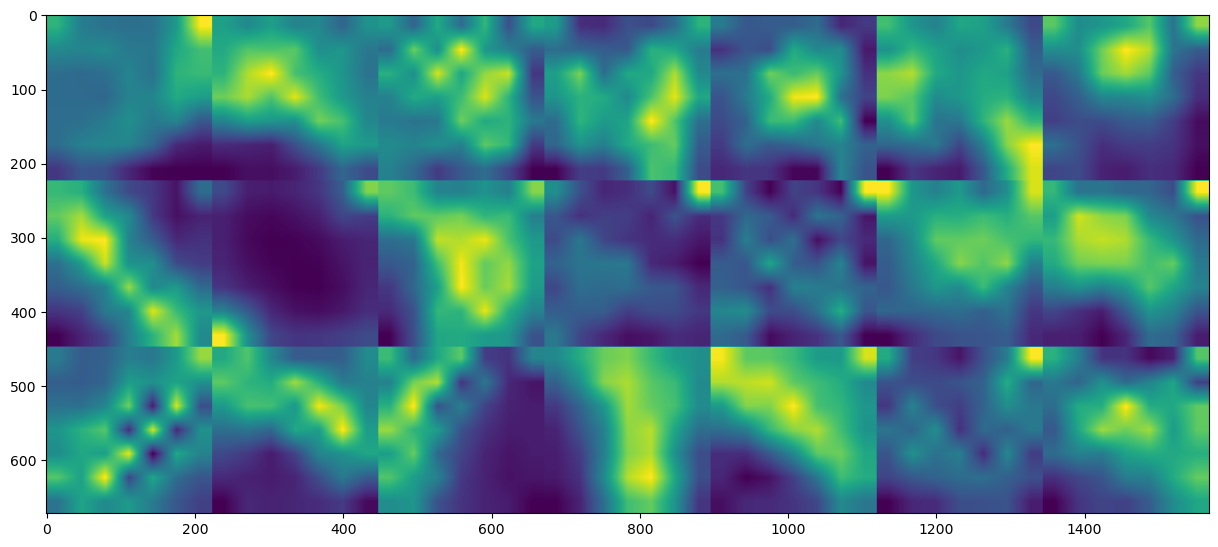

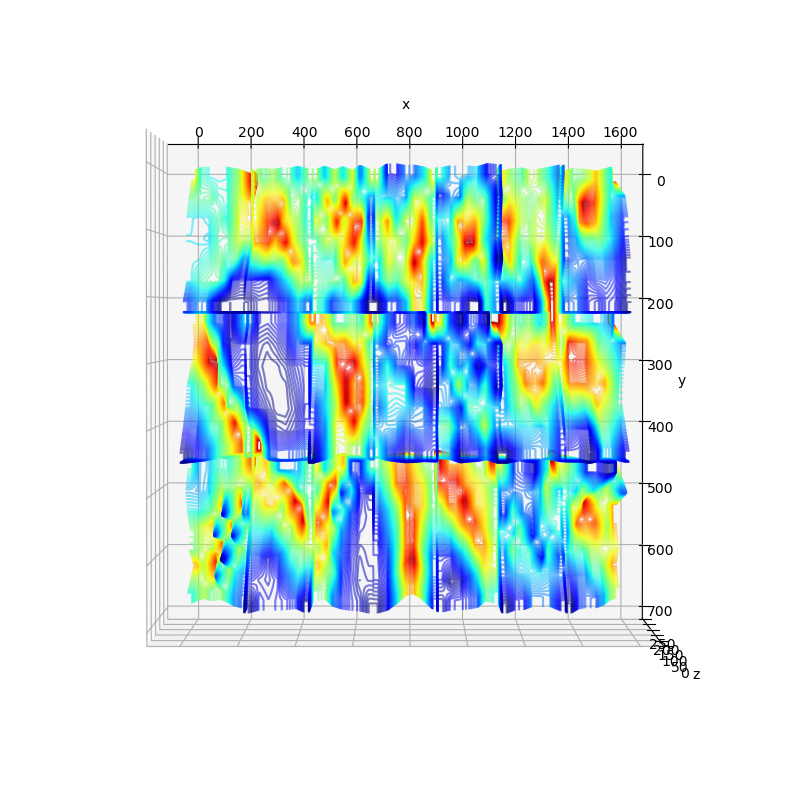

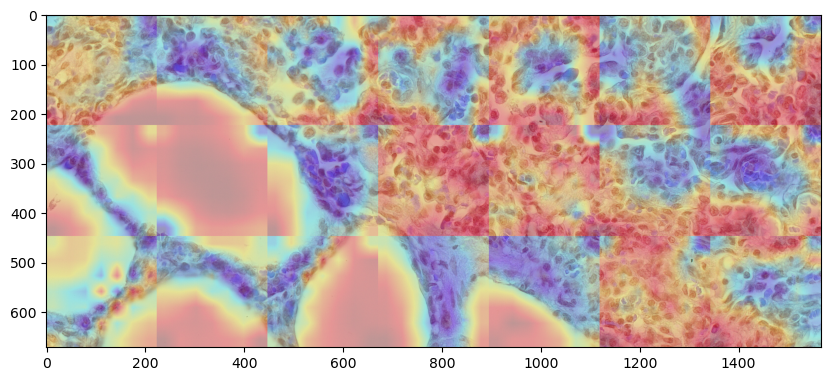

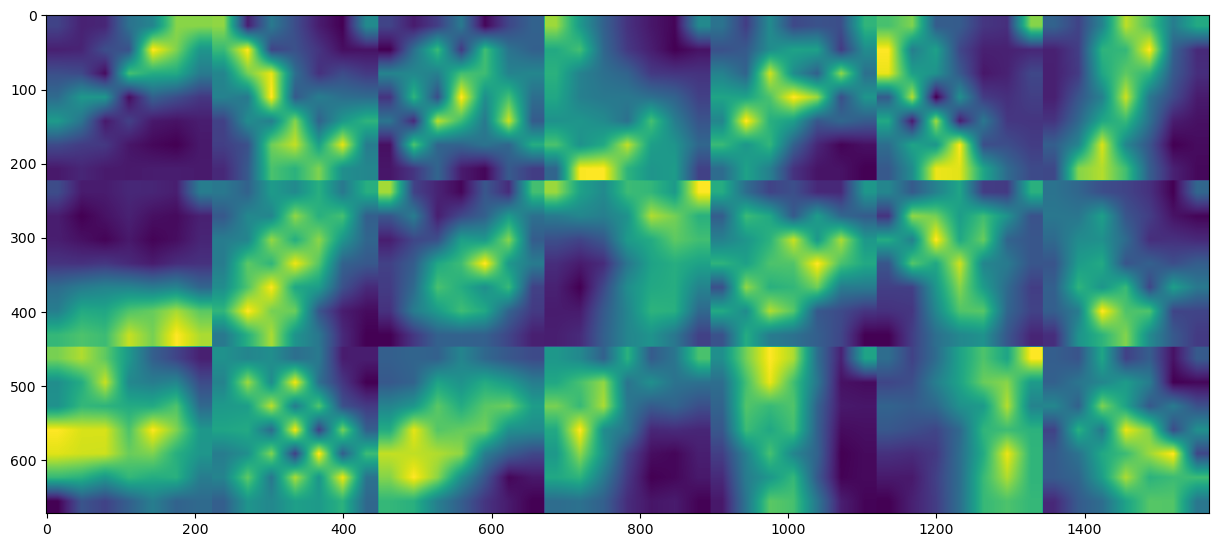

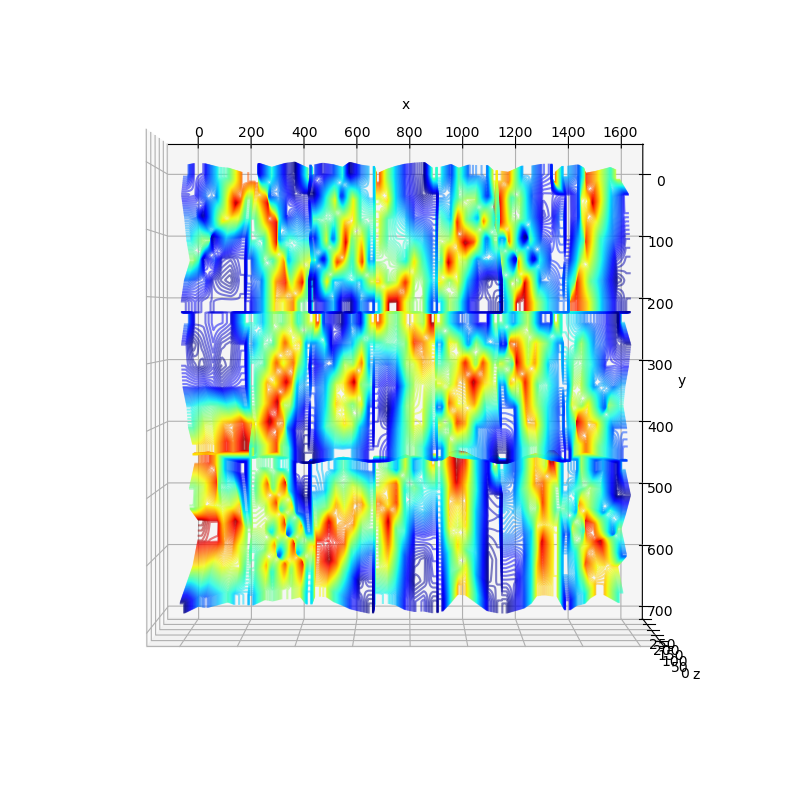

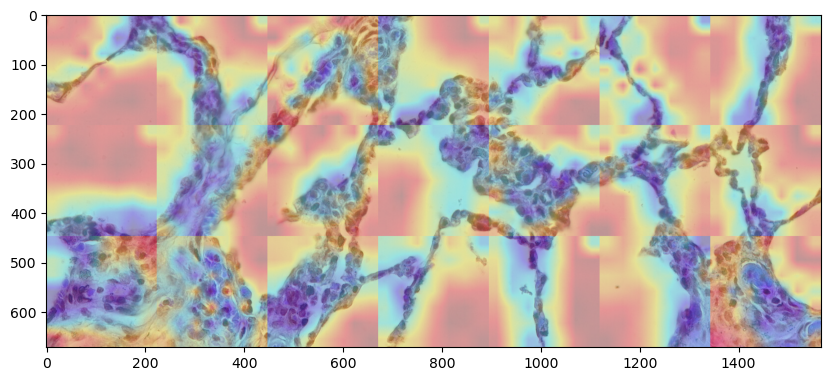

In [26]:
### This cell is almost the same for Effnet model 
### Path to model files and also the index of layers are different
### we continued to work with this two models and visualize the local activated heatmap

val_dirs = VALIDATION_DIR
for val_dir in val_dirs:
    inputs = tf.keras.Input(shape=(224,224,3))

    ### The model is defined here 
    x = EfficientNetB4(           ### Functional model
      input_tensor=inputs, 
      include_top=False,
      weights='imagenet'
    )
    
    x.trainable = False  #The layers are not trainable
   
    layer_type = LAYER_ACTIVATION   ## We tried different activation layers 
    x = tf.keras.layers.Flatten(name='flatten')(x.output)
    x = tf.keras.layers.Dense(128, activation=layer_type, name='fc1')(x)
    x = tf.keras.layers.Dense(128, activation=layer_type, name='fc2')(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
    x = tf.keras.layers.Dense(3, activation='softmax', name='predictions')(x)

    ##x.summary()
    '''
    top_conv (Conv2D)              (None, 7, 7, 1792)   802816      ['block7b_add[0][0]']            
                                                                                                  
    top_bn (BatchNormalization)    (None, 7, 7, 1792)   7168        ['top_conv[0][0]']               
                                                                                                  
    top_activation (Activation)    (None, 7, 7, 1792)   0           ['top_bn[0][0]']                 
                                                                                                  
    flatten (Flatten)              (None, 87808)        0           ['top_activation[0][0]']         
                                                                                                  
    fc1 (Dense)                    (None, 128)          11239552    ['flatten[0][0]']                
                                                                                                  
    fc2 (Dense)                    (None, 128)          16512       ['fc1[0][0]']                    
                                                                                                  
    dropout (Dropout)              (None, 128)          0           ['fc2[0][0]']                    
                                                                                                  
    predictions (Dense)            (None, 3)            387         ['dropout[0][0]']                
                                                                                       
    '''
    
    
    
    
    ## Same metrics to track here
    METRICS = [
      keras.metrics.SparseCategoricalAccuracy(),
      MulticlassTruePositives()]


    #Create the model 
    pretrained_model = tf.keras.Model(inputs, x)

    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=METRICS)
    
    weights = glob.glob(MODELS+'*_best_weights.*')[0]  ## Load weights trained before (Not every model there)
   
    ### This is important to load the model from trained weights
    ### It is necessary to include new objects or classes the defined for the model here
    loaded_1 = keras.models.load_model(
        weights, custom_objects={"MulticlassTruePositives": MulticlassTruePositives,'Functional':EfficientNetB4()}
    )

    #loaded_1.summary()
    weights_list = loaded_1.get_weights()
    model_index  = [475,476,478]   ## The index of layers in original EffnetB4 model
    weight_index = [3,4,6]         ##    
    for i,weights in zip(model_index,weight_index):
        pretrained_model.layers[i].set_weights(loaded_1.layers[weights].get_weights())


    model=pretrained_model

    gradModel = Model(
          inputs=[pretrained_model.inputs],
          outputs=[pretrained_model.get_layer('top_conv').output,pretrained_model.get_layer('fc1').output,
                  pretrained_model.output])


    imgs = glob.glob(SAMPLES+val_dir+'/*.tif')

    for im in imgs:
        img_path = im
       
        if cv2.imread(img_path) is not None:
            input_img = cv2.imread(img_path)
            ## This is for chacking all tiles in an image and stitch them together at the end
            max_tile_i = int(np.floor(input_img.shape[0]/224))
            max_tile_j = int(np.floor(input_img.shape[1]/224))
            Heatmap_2D   = np.zeros([max_tile_i*224,max_tile_j*224])
            Heatmap_only = np.zeros([max_tile_i*224,max_tile_j*224,1])
            Gradcam_img  = np.zeros([max_tile_i*224,max_tile_j*224,3])
            img_title = np.zeros([max_tile_i,max_tile_j])
            for i in range(max_tile_i):
                for j in range(max_tile_j):
                    tmp_img = input_img[224*i:224*(i+1),224*j:224*(j+1),:]
                    tmp_img = cv2.resize(tmp_img,(224,224))
                    y = np.expand_dims(tmp_img, axis=0)
                    img_array = y

                    with tf.GradientTape() as tape:
                        #same as VGG for calculating the gradient of loss w.r.t last convolution layer
                        inputs = tf.cast(img_array, tf.float32)
                        convOutputs, fc1,predictions = gradModel(inputs)
                        #convoutput.shape:  (7, 7, 1792)
                        ## We need the predicted class here
                        loss = predictions[:, np.argmax(predictions)]
                        #loss.shape:  (1,)

                        img_title[i,j] = np.argmax(predictions)
                        
                        # use automatic differentiation to compute the gradients
                        grads = tape.gradient(loss, convOutputs)
                        #grads.shape:  (1, 7, 7, 1792)


                        
                        # compute the guided gradients (took the positive part)
                        castConvOutputs = tf.cast(convOutputs > 0, "float32")
                        castGrads = tf.cast(grads > 0, "float32")
                        guidedGrads = castConvOutputs * castGrads * grads 
                        #guidedgtads.shape:  (1,7, 7, 1792)


                       ## Discard the batch dimension
                        convOutputs = convOutputs[0]
                        guidedGrads = guidedGrads[0]
                        #guidedgtads.shape:  (7, 7, 1792)
                       
                        # compute the average of the gradient values, and using them as weights,
                        #compute the effect of fiters with respect to the weights
                        weights = tf.reduce_mean(guidedGrads, axis=(0, 1)) 
                        # weights.shape: (1792,)

                        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
                        # Cam.shape: (7, 7)
                        # grab the spatial dimensions of the input image and resize
                        # the output class activation map to match the input image
                        # dimensions
                        (w, h) = (img_array.shape[2], img_array.shape[1])  
                        heatmap = cv2.resize(cam.numpy(), (w, h))
                        numer = heatmap - np.min(heatmap)
                        denom = (heatmap.max() - heatmap.min())
                        if denom == 0:
                            denom = denom + 0.0000000000000001
                        heatmap = 255*numer / denom

                        Heatmap_2D[224*i:224*(i+1),224*j:224*(j+1)] = heatmap[:,:]
                        stacked_img = np.stack((heatmap,), axis=-1)
                        im_color = cv2.applyColorMap(stacked_img.astype(np.uint8), cv2.COLORMAP_JET)

                        Heatmap_only[224*i:224*(i+1),224*j:224*(j+1)] = stacked_img[:,:,:]
                        super_imposed_img = cv2.addWeighted((im_color).astype(np.uint8), 0.3, tmp_img, 0.7,0)
                        Gradcam_img[224*i:224*(i+1),224*j:224*(j+1),:] =  super_imposed_img 


            ### This part is for plot and saving##########################################
            
            ### Plotting only heatmap
            plt.figure(figsize=(15,15))
            plt.imshow(Heatmap_2D)
            plt.savefig(img_path+'_heatmap.png')
           
            ### Plotting 3D plot of Heatmap as Z axis
            fig   = plt.figure(figsize=(10,10))
            ax    = plt.axes(projection='3d')
            x     = np.arange(0,max_tile_j*224,1)
            y     = np.arange(0,max_tile_i*224,1)
            X, Y  = np.meshgrid(x, y)
            ax.contour3D(X,Y, Heatmap_only[:,:,0], 100,alpha = 0.5, cmap='jet')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.view_init(azim=270, elev=-89)
            plt.savefig(img_path+'_3D.png')


            
            ### Plotting image with GRAD-CAM filter added 
            plt.figure(figsize=(10,10))
            plt.imshow(Gradcam_img.astype(np.uint8))
            norm = mpl.colors.Normalize(vmin=Gradcam_img.min(), vmax=Gradcam_img.max())
            plt.savefig(img_path+'_img_filter.png')
